# LPS and LCS in Human Chromosome 22

In [ ]:
using Plots
using DataFrames
using DelimitedFiles
using StringAlgorithms
using LaTeXStrings
include("source/utils.jl")
include("source/io.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
include("source/chromosome.jl")
include("source/expectation.jl")

### Human Chromosome 22
Retrieve chromosome 22 on NCBI Nucleotide.
- <a href="https://www.ncbi.nlm.nih.gov/nuccore/NC_000022?report=fasta">GRCh38.p14 Primary Assembly /  NC_000022.11</a>

Download the sequence file in FASTA format using the `Send to` dropdown menu.
<img src="assets/ncbinucleotidesendto.png"/>

### NCBI Gene Annotations
Retrieve annotations for chromosome 22 e.g., using the NCBI Gene queries from <a href="https://en.wikipedia.org/wiki/Chromosome_22#cite_note-NCBI_coding-9">Wikipedia</a>.
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%22genetype%20protein%20coding%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Protein-coding gene annotations </a>
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%28%22genetype%20miscrna%22%5BProperties%5D%20OR%20%22genetype%20ncrna%22%5BProperties%5D%20OR%20%22genetype%20rrna%22%5BProperties%5D%20OR%20%22genetype%20trna%22%5BProperties%5D%20OR%20%22genetype%20scrna%22%5BProperties%5D%20OR%20%22genetype%20snrna%22%5BProperties%5D%20OR%20%22genetype%20snorna%22%5BProperties%5D%29%20NOT%20%22genetype%20protein%20coding%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Noncoding RNA annotations </a>
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%22genetype%20pseudo%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Pseudogene annotations </a>
    
Download each annotation file in tabular text format using the `Send to` dropdown menu.
<img src="assets/ncbigenesendto.png"/>

### Masking with tantan
Run `tantan` on `data/ncbi_chr22_sequence.fasta` to mask repetitive and low-complexity regions; store the masked file in `data/ncbi_chr22_masked_sequence.fasta`. Rather than using lowercase letters for masks, configure tantan to mask with 'N' characters with the `-x N` argument. The proceeding script will automatically remove these along with the other 'N' characters already present in the chromosome.

```
tantan -x N data/ncbi_chr22_sequence.fasta > data/ncbi_chr22_masked_sequence.fasta
```

In [ ]:
chromosome = loadchromosome("data/ncbi_chr22_sequence.fasta")
masked_chromosome = loadchromosome("data/ncbi_chr22_masked_sequence.fasta")
protein_annotation = loadannotation("data/ncbi_chr22_protein.txt")
rna_annotation = loadannotation("data/ncbi_chr22_rna.txt")
pseudogene_annotation = loadannotation("data/ncbi_chr22_pseudo.txt")

protein = annotate(chromosome, protein_annotation)
rna = annotate(chromosome, rna_annotation)
pseudogene = annotate(chromosome, pseudogene_annotation)

masked_protein = annotate(masked_chromosome, protein_annotation)
masked_rna = annotate(masked_chromosome, rna_annotation)
masked_pseudogene = annotate(masked_chromosome, pseudogene_annotation)

shuf_protein = shufflefast.(protein)
shuf_rna = shufflefast.(rna)
shuf_pseudogene = shufflefast.(pseudogene);

In [ ]:
print("λ₂ = ")
println(coincidence(join(protein, rna, pseudogene)))

### Compute LPS and LCS

In [ ]:
function llcs(x, y, progressmeter)
    next!(progressmeter)
    length(longestcommonsubstring(x, y)[1])
end
function llps(x, progressmeter)
    next!(progressmeter)
    length(longestpalindromicsubstring(x))
end
function generate_lps(x, resultpath)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llps(x[i], p)
    end
    lx = length.(x)
    print("writing LPS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, results], ["length", "lps"]))
end
function generate_lcs(x, y, resultpath)
    @assert length(x) == length(y)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llcs(x[i], y[i], p)
    end
    lx = length.(x)
    ly = length.(y)
    print("writing LCS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, ly, results], ["length1", "length2", "lcs"]))
end

In [ ]:
resultpaths = [
    "outputs/lcs_proteincoding_shuf.txt", 
    "outputs/lcs_rnacoding_shuf.txt", 
    "outputs/lcs_pseudogene_shuf.txt", 
    "outputs/lps_proteincoding.txt", 
    "outputs/lps_rnacoding.txt", 
    "outputs/lps_pseudogene.txt", 
    "outputs/lps_shuf_proteincoding.txt", 
    "outputs/lps_shuf_rnacoding.txt", 
    "outputs/lps_shuf_pseudogene.txt", 
    "outputs/lps_hardmasked_proteincoding.txt",
    "outputs/lps_hardmasked_rnacoding.txt",
    "outputs/lps_hardmasked_pseudogene.txt"]
generate_lcs(protein, shuf_protein, resultpaths[1])
generate_lcs(rna, shuf_rna, resultpaths[2])
generate_lcs(pseudogene, shuf_pseudogene, resultpaths[3])
generate_lps(protein, resultpaths[4])
generate_lps(rna, resultpaths[5])
generate_lps(pseudogene, resultpaths[6])
generate_lps(shuf_protein, resultpaths[7])
generate_lps(shuf_rna, resultpaths[8])
generate_lps(shuf_pseudogene, resultpaths[9])
generate_lps(masked_protein, resultpaths[10])
generate_lps(masked_rna, resultpaths[11])
generate_lps(masked_pseudogene, resultpaths[12])

## Plot [python]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
from math import *
cluster = lambda data, parameter, lo, hi : [data[parameter==x] for x in range(lo,hi+1)]
robust_cluster_means = lambda data_clusters : [stats.mean(cluster) if len(cluster)>0 else 0 for cluster in data_clusters]
def scatter_cluster_means(axis, frame, datakey, parakey, lo, hi, color, marker, label):
    clusters = cluster(frame[datakey], frame[parakey], lo, hi)
    x = robust_cluster_means(clusters)
    y = list(range(lo,hi+1))
    axis.scatter(y, x, 1, 
                 color=color, label=label, marker=marker, alpha=0.2)
exp_lcs = lambda n, lambda2: 2*log(n, 1/lambda2)
exp_lps = lambda n, lambda2: exp_lcs(n, lambda2) + 1
def plot_expected_lcs(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lcs(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LCS]")
def plot_expected_lps(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lps(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LPS]")
def setup_axis1(axis,lo,hi):
    axis.set_xlim(lo,hi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length")
    axis.set_ylim(0,120)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length")
    leg = axis.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
def setup_axis2(axis,lo,hi):
    axis.set_xlim(lo,hi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length")
    axis.set_ylim(0,40)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length")
    leg = axis.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

In [ ]:
resultpaths = [
    "outputs/lcs_proteincoding_shuf.txt", 
    "outputs/lcs_rnacoding_shuf.txt", 
    "outputs/lcs_pseudogene_shuf.txt", 
    "outputs/lps_proteincoding.txt", 
    "outputs/lps_rnacoding.txt", 
    "outputs/lps_pseudogene.txt", 
    "outputs/lps_shuf_proteincoding.txt", 
    "outputs/lps_shuf_rnacoding.txt", 
    "outputs/lps_shuf_pseudogene.txt", 
    "outputs/lps_hardmasked_proteincoding.txt",
    "outputs/lps_hardmasked_rnacoding.txt",
    "outputs/lps_hardmasked_pseudogene.txt"]

(lcs_protein_shuf, lcs_rna_shuf, lcs_pseudogene_shuf, 
 lps_protein, lps_rna, lps_pseudogene, 
 lps_shuf_protein, lps_shuf_rna, lps_shuf_pseudogene, 
 lps_masked_protein, lps_masked_rna, lps_masked_pseudogene) = [pd.read_csv(x) for x in resultpaths]

# coincidence frequency for our annotation of chr22
lambda2 = 0.25080397536793314

lcsmaroon = "#8a1414"
sprotblue = "#0000ff"
shufred = "#ff0000"
maskgreen = "#0cff0c"

lo = lo_protein = lo_rna = lo_pseudogene = 1
hi = hi_protein = hi_rna = hi_pseudogene = int(1e6)

In [ ]:
from time import time

In [ ]:
fig, ax = plt.subplots(dpi=800)
start_time = time()
print(1, time() - start_time)
scatter_cluster_means(ax, lcs_protein_shuf, "lcs", "length1", lo_protein, hi_protein,
                      lcsmaroon, 's', "LCS(protein, shuf)")
print(2, time() - start_time)
scatter_cluster_means(ax, lcs_rna_shuf, "lcs", "length1", lo_rna, hi_rna,
                      lcsmaroon, 's', "LCS(rna, shuf)")
print(3, time() - start_time)
scatter_cluster_means(ax, lcs_pseudogene_shuf, "lcs", "length1", lo_pseudogene, hi_pseudogene,
                      lcsmaroon, 's', "LCS(pseudogene, shuf)")
print(4, time() - start_time)
plot_expected_lcs(ax, lambda2, lo, hi, lcsmaroon)
print(5, time() - start_time)
scatter_cluster_means(ax, lps_shuf_protein, "lps", "length", lo_protein, hi_protein,
                      shufred, 'o', "LPS(shuf-protein)")
print(6, time() - start_time)
scatter_cluster_means(ax, lps_shuf_rna, "lps", "length", lo_rna, hi_rna,
                      shufred, 'o', "LPS(shuf-rna)")
print(7, time() - start_time)
scatter_cluster_means(ax, lps_shuf_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred, 'o', "LPS(shuf-pseudogene)")
print(8, time() - start_time)
plot_expected_lps(ax, lambda2, lo, hi, shufred)
print(9, time() - start_time)
scatter_cluster_means(ax, lps_protein, "lps", "length", lo_protein, hi_protein,
                      sprotblue, '^', "LPS(protein)")
print(10, time() - start_time)
scatter_cluster_means(ax, lps_rna, "lps", "length", lo_rna, hi_rna,
                      sprotblue, '^', "LPS(rna)")
print(11, time() - start_time)
scatter_cluster_means(ax, lps_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      sprotblue, '^', "LPS(pseudogene)")
print(12, time() - start_time)
setup_axis1(ax,lo,hi)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_a.png")

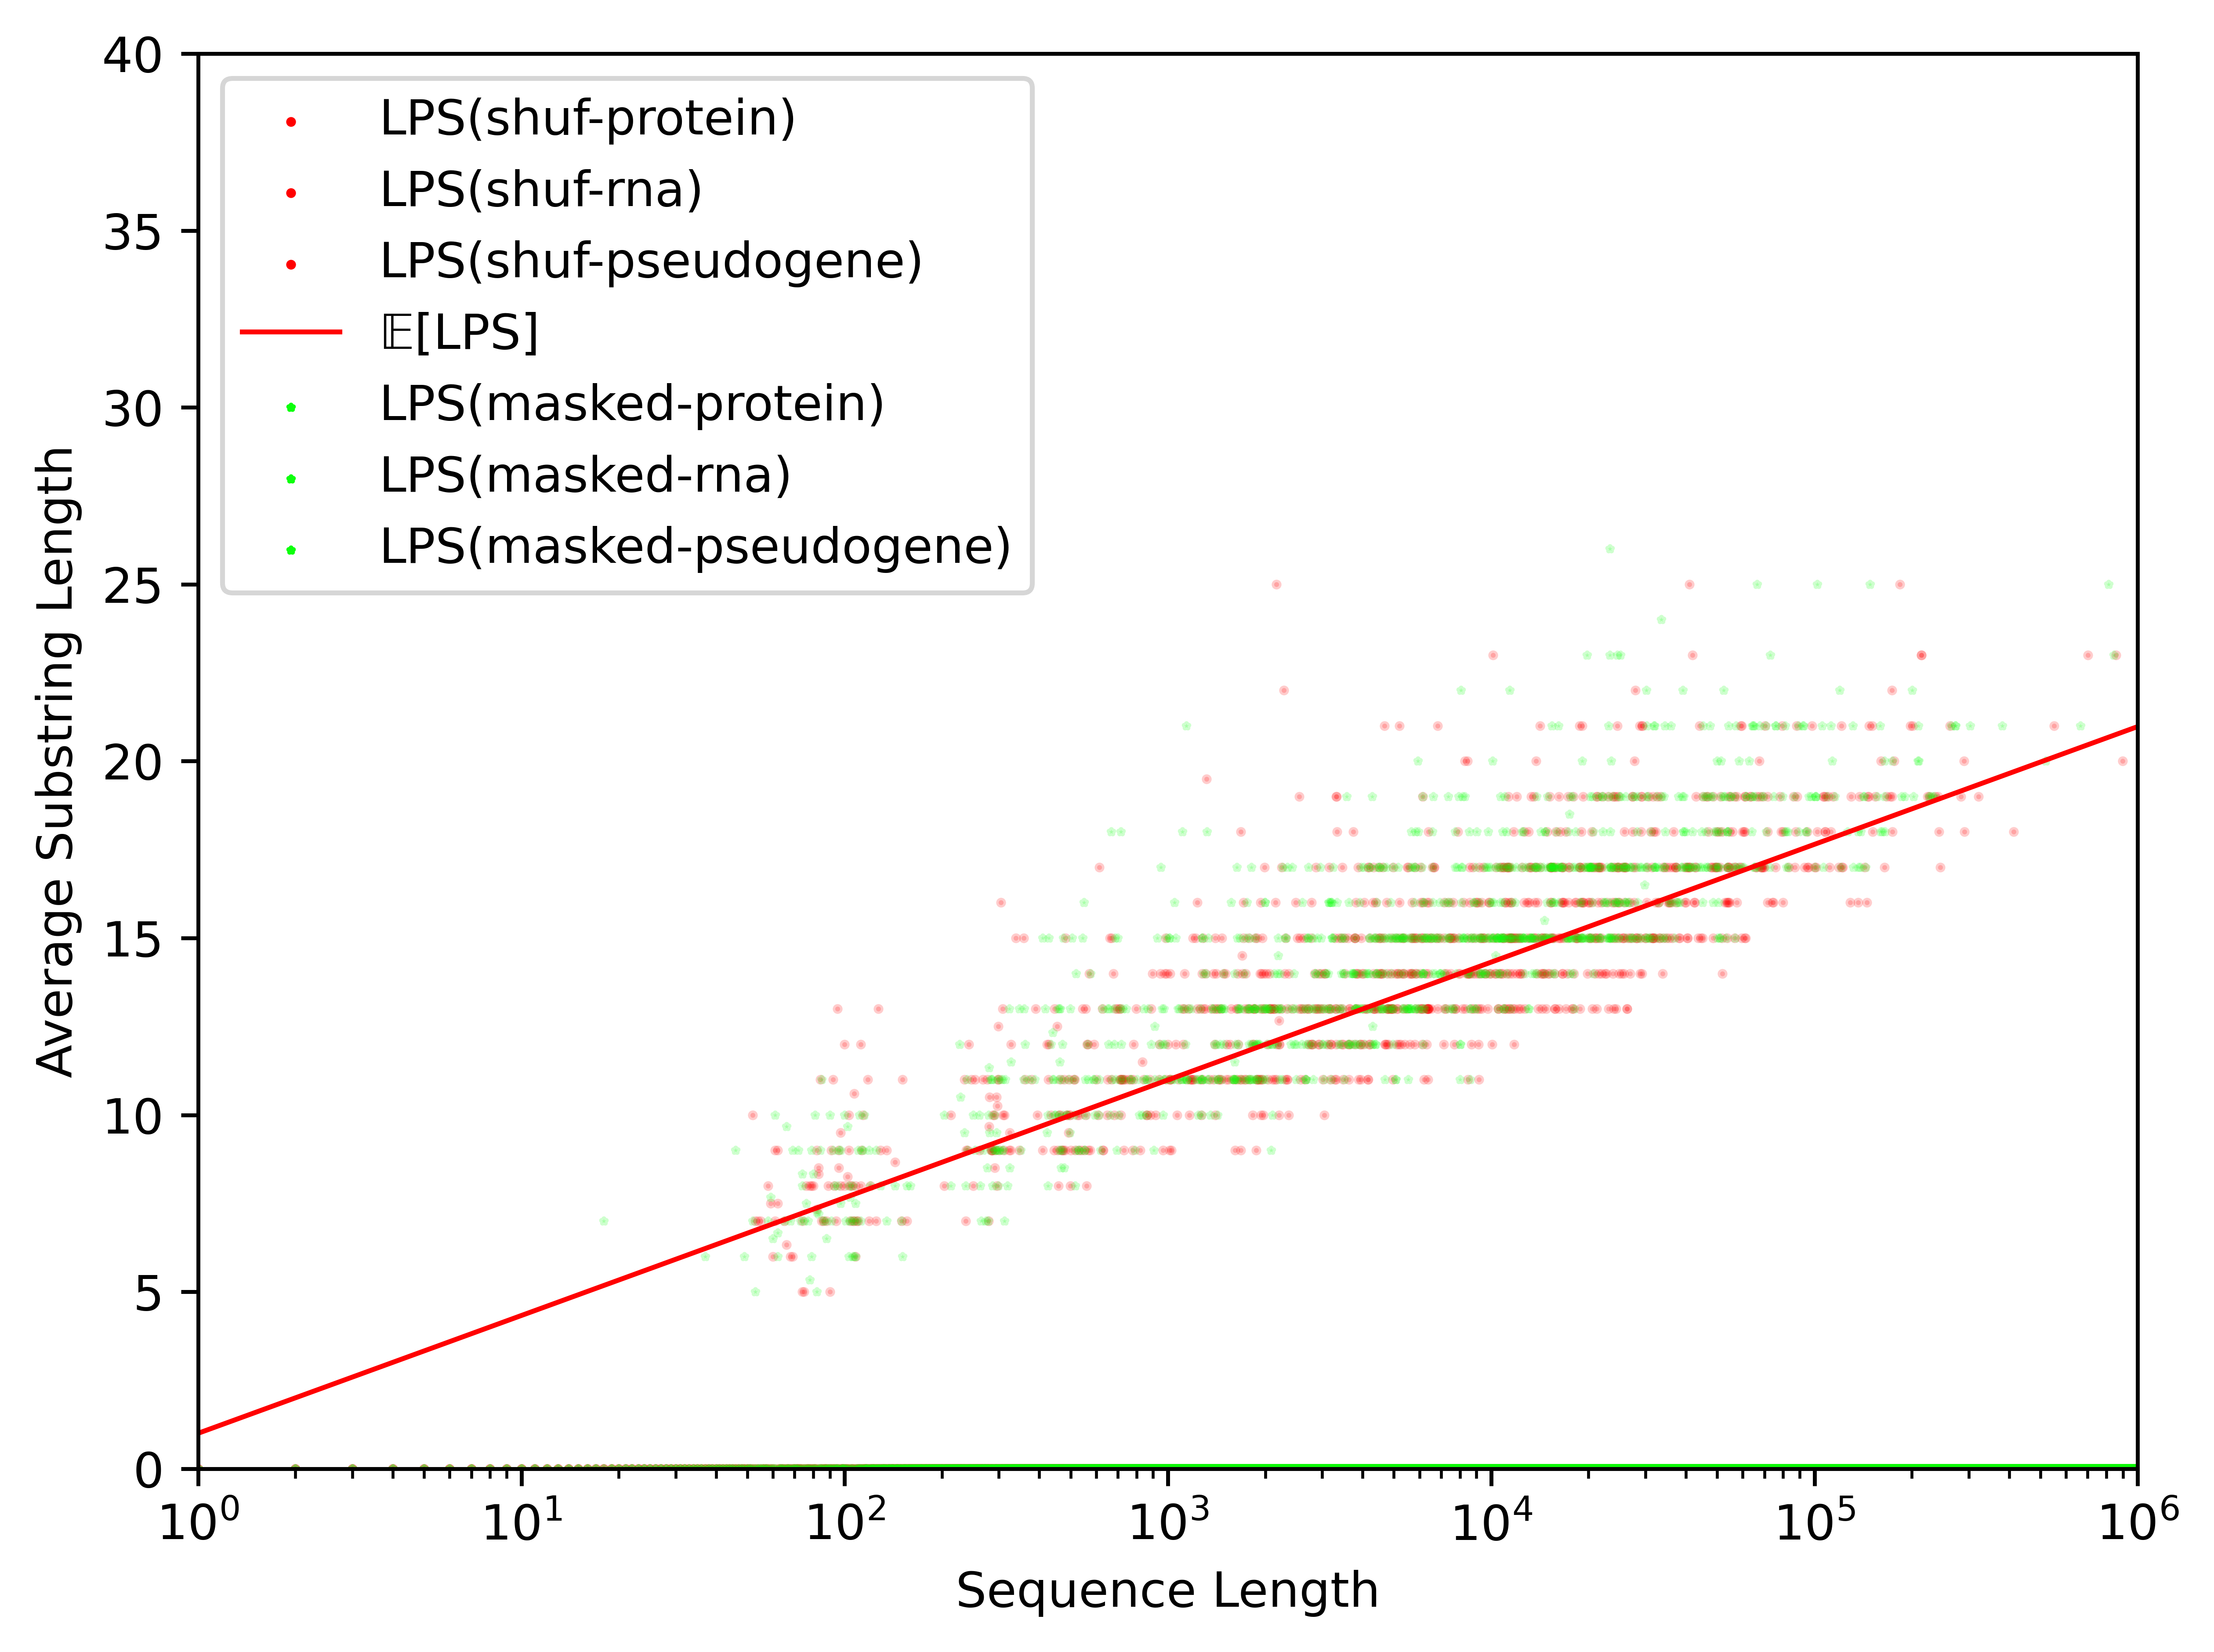

In [7]:
fig,ax = plt.subplots(dpi=800)
scatter_cluster_means(ax, lps_shuf_protein, "lps", "length", lo_protein, hi_protein,
                      shufred, 'o', "LPS(shuf-protein)")
scatter_cluster_means(ax, lps_shuf_rna, "lps", "length", lo_rna, hi_rna,
                      shufred, 'o', "LPS(shuf-rna)")
scatter_cluster_means(ax, lps_shuf_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred, 'o', "LPS(shuf-pseudogene)")
plot_expected_lps(ax, lambda2, lo, hi, shufred)

scatter_cluster_means(ax, lps_masked_protein, "lps", "length", lo_protein, hi_protein,
                      maskgreen, '*', "LPS(masked-protein)")
scatter_cluster_means(ax, lps_masked_rna, "lps", "length", lo_rna, hi_rna,
                      maskgreen, '*', "LPS(masked-rna)")
scatter_cluster_means(ax, lps_masked_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      maskgreen, '*', "LPS(masked-pseudogene)")
setup_axis2(ax,lo,hi)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_b.png")